In [0]:
# Find the best channel using Logistic Regression with Lasso but with a pre define value for C
from sklearn.model_selection import train_test_split
import sklearn.model_selection
import scipy.io
import os
import re
import numpy as np
import warnings
warnings.simplefilter(action = "ignore" ,category =FutureWarning)
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import linear_model,preprocessing
logreg = linear_model.LogisticRegression(C=1e5,penalty='l2')
#logreg = linear_model.LogisticRegression(C=1e5)
files = os.listdir("./data")
acc = np.zeros(59)
for file in files:
  
  index =((re.search('Ch_(.*).mat',file)).group(1))
  mat = scipy.io.loadmat(file)
  X = mat['Ch_Matrix']
  y=mat['y']
  y= np.ravel(y)
  # Scale the data
  X_scale = np.interp(X,(X.min(),X.max()),(-1,+1))
  Xtr,Xts,Ytr,Yts = train_test_split(X_scale,y,test_size=0.33,shuffle=True) 
  logreg.fit(Xtr, Ytr)
  yhat = logreg.predict(Xts)
  acc[int(index)] = np.mean(yhat == Yts)
  

In [18]:
print ('Max Accuracy is {0:f}'.format(np.max(acc)))
print ('Channel with max accuracy is : {0:d}'.format(np.argmax(acc)))

Max Accuracy is 0.539095
Channel with max accuracy is : 1


In [3]:
# Find Optimal C for the channel with maximum Accuracy using cross validation

#Find the best value of C
from sklearn.model_selection import KFold
npen = 20
C_test = np.logspace(-2,2,npen)

# Create the cross-validation object and error rate matrix
nfold = 10
kf = KFold(n_splits=nfold,shuffle=True)
err_rate = np.zeros((npen,nfold))
num_nonzerocoef = np.zeros((npen,nfold))
# Create the logistic regression object
logreg = linear_model.LogisticRegression(penalty='l1',warm_start=True)

# Loop over the folds in the cross-validation
# Get the channel file with max accuracy
mat = scipy.io.loadmat('Ch_35.mat')
X = mat['Ch_Matrix']
y=mat['y']
y= np.ravel(y)
# Scale the data
X_scale = np.interp(X,(X.min(),X.max()),(-1,+1))
for ifold, Ind in enumerate(kf.split(X_scale)):        
            
    # Get training and test data
  Itr, Its = Ind
  Xtr = X_scale[Itr,:]
  ytr = y[Itr]
  Xts = X_scale[Its,:]
  yts = y[Its]
    
    # Loop over penalty levels
  for ipen, c in enumerate(C_test):
        
    # Set the penalty level      
    logreg.C= c
    
    # Fit a model on the training data
    logreg.fit(Xtr, ytr)
    
    # Predict the labels on the test set.
    yhat = logreg.predict(Xts)
        
    # Measure the accuracy
    err_rate[ipen,ifold] = np.mean(yhat != yts)
    num_nonzerocoef[ipen,ifold]=np.sum(abs(logreg.coef_)>0.001)
  print("Fold %d" % ifold)
    


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9


The minimum test error rate =   4.6241e-01, SE=  5.2686e-03
The C value corresponding to minimum error =   7.8476e-01
Optimal C=  4.2813e-02
The test error rate =   4.6692e-01, SE=  7.6256e-03
Accuracy =  0.5331, SE=0.0076


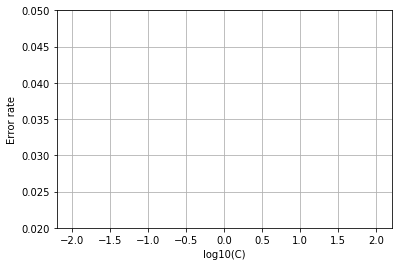

In [4]:
# Plot the error rate
import matplotlib.pyplot as plt
err_mean = np.mean(err_rate, axis=1)
num_nonzerocoef_mean = np.mean(num_nonzerocoef, axis=1)
err_se = np.std(err_rate,axis=1)/np.sqrt(nfold-1)
plt.errorbar(np.log10(C_test), err_mean, marker='o',yerr=err_se)
plt.ylim([0.02,0.05])
plt.grid()
plt.xlabel('log10(C)')
plt.ylabel('Error rate')

imin = np.argmin(err_mean)

print("The minimum test error rate = %12.4e, SE=%12.4e" % (err_mean[imin], err_se[imin]))
print("The C value corresponding to minimum error = %12.4e" % (C_test[imin]))

err_tgt = err_mean[imin] + err_se[imin]
iopt = np.where(err_mean < err_tgt)[0][0]
C_opt = C_test[iopt]

print("Optimal C=%12.4e" % C_opt)
print("The test error rate = %12.4e, SE=%12.4e" % (err_mean[iopt], err_se[iopt]))

print('Accuracy =  {0:.4f}, SE={1:.4f}'.format(1-err_mean[iopt], err_se[iopt]))


In [5]:
# find the channel with optimal C using cross validation
logreg = linear_model.LogisticRegression(C=C_opt,penalty='l1')
logreg.C= C_opt
files = os.listdir("./data")
# Number of folds
nfold=10

kf=sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)
acc=np.zeros((59,nfold))
i =0
for file in files:
  index =((re.search('Ch_(.*).mat',file)).group(1))
  mat = scipy.io.loadmat(file)
  X = mat['Ch_Matrix']
  
  y=mat['y']
  y= np.ravel(y)
  
  # Loop over the folds
  for isplit,Ind in enumerate(kf.split(X)):
    print("fold = %d "%isplit)
	# Get the training data in the split
    Itr,Its=Ind
	
	#Xtr,Xts,Ytr,Yts = train_test_split(X,y,test_size=0.33,shuffle=True) 
    Xtr = X[Itr]
    Ytr = y[Itr]
    Xts = X[Its]
    Yts = y[Its]
    
    Xtr_scale = np.interp(Xtr,(Xtr.min(),Xtr.max()),(-1,+1))
    Xts_scale = np.interp(Xts,(Xts.min(),Xts.max()),(-1,+1))
    logreg.fit(Xtr, Ytr)
    yhat = logreg.predict(Xts)
    acc[int(index),isplit] =np.mean(yhat == Yts)

#get the mean of accuracies over all splits
acc_mean=np.mean(acc,axis=1)

#pick the one with max accuracy
print ('Max Accuracy is {0:f}'.format(np.max(acc_mean)))

#Maximum Accuracy is for channel
print ('Channel with max accuracy is : {0:d}'.format(np.argmax(acc_mean)))

#Top 5 channels with best accuracy are :
print(np.argsort(acc_mean)[-5:]+1)


fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 
Max Accuracy is 0.535785
Channel with max accuracy is : 30
[24 48  2 11 31]


In [12]:
#pick the one with max accuracy
print ('Max Accuracy is {0:f}'.format(np.max(acc_mean)))

#Maximum Accuracy is for channel
print ('Channel with max accuracy is : {0:d}'.format(np.argmax(acc_mean)))

#Top 5 channels with best accuracy are :
print(np.argsort(acc_mean)[-5:])
max_accuracies_ch_number = np.argsort(acc_mean)[-5:]
max_accuracies =np.zeros(5)

for i in max_accuracies_ch_number:
  print(acc_mean[i])
  
  
  

Max Accuracy is 0.535785
Channel with max accuracy is : 30
[23 47  1 10 30]
0.5332974215327156
0.5339802587701747
0.5350955766922153
0.5357707185438279
0.5357850832640749


0.5339802587701747
